# Datathon ML - MEBDS

**Author: Jaime Blanco Linares**

Kaggle competition's [link](https://www.kaggle.com/competitions/embds2021-22/data).

# Imports, initializations and functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from keras import layers
# from scipy import stats

import itertools
import copy
import time
import datetime
import pickle

# print(tf.__version__)
%matplotlib inline
# pd.set_option('display.max_columns', 50)

In [2]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
def plot_corr_matrix(df, method_='pearson'):
    # Generate correlation matrix in Pandas
    corr = df.select_dtypes(include=np.number).corr(method=method_)

    # Mask to show only one triangle and improve the presentation
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Plotea correlation matrix
    f, ax = plt.subplots(figsize=(20, 15))
    sns.heatmap(corr, mask=mask, annot=True, cmap='RdBu_r', center=0)
    plt.show()

In [4]:
def first_scan(df):
    print('Null values for each variable:')
    print(df.isna().sum())
    print('----------------------------\n')
    print('\nData types:')
    print(df.dtypes)
    print('----------------------------\n')
    # Every single feature is object, so count & display
    # values to infer which type we should cast them to
    for col_name in df.columns:
        if(df[col_name].dtype == 'object'):
            print('\nVariable: ', col_name)
            print(df[col_name].value_counts())
            print('--------------------')

In [5]:
def to_dummies(df):
    #make j categorical feature with n unique values as n diferent binary features
    dummed_features = []
    for col_name in df.columns:
        if(df[col_name].dtype == 'object'):
            print(col_name + ' expanded to ' + str(len(df[col_name].unique())) + ' columns')
            j = pd.get_dummies(df[col_name], prefix=col_name)
            df = pd.concat([df, j], axis=1)
            dummed_features.append(col_name)

    # remove all transformed features. Although is not recomended to remove features,
    # this is done for simplicity
    df = df[df.columns.difference(dummed_features)]

    # Delete blank spaces in the column names  generated by the conversion to dummies.
    df.columns = df.columns.str.replace(' ', '')
    
    return df

In [6]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns', None)

# Data processing

**Reading data**

In [7]:
target = 'SalePrice'
df = pd.read_csv('train.csv', index_col=False)
print(df.shape)
df.head()

(2302, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,20,RL,64.0,10475,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,1Story,8,5,2008,2008,Gable,CompShg,VinylSd,VinylSd,Stone,72.0,Gd,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,1694,1694,GasA,Ex,Y,SBrkr,1694,0,0,1694,0.0,0.0,2,0,3,1,Gd,7,Typ,0,NaN,Attchd,2008.0,RFn,3.0,776.0,TA,TA,Y,160,33,0,0,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal,245350.0
1,2,90,RL,NaN,18890,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Feedr,RRAe,Duplex,1.5Fin,5,5,1977,1977,Shed,CompShg,Plywood,Plywood,None,1.0,TA,TA,CBlock,Gd,TA,No,GLQ,498,Rec,211,652,1361,GasA,Ex,Y,SBrkr,1361,1259,0,2620,0.0,0.0,2,2,4,2,TA,12,Typ,1,TA,BuiltIn,1977.0,RFn,2.0,600.0,TA,TA,N,155,24,145,0,0,0,NaN,NaN,Gar2,8300,8,2007,WD,Normal,190000.0
2,3,80,RL,NaN,21453,Pave,NaN,IR1,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,SLvl,6,5,1969,1969,Flat,Metal,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Gd,ALQ,938,Unf,0,0,938,GasA,Ex,Y,SBrkr,988,0,0,988,1.0,0.0,1,0,1,1,TA,4,Typ,2,TA,Attchd,1969.0,Unf,2.0,540.0,TA,TA,Y,0,130,0,130,0,0,NaN,NaN,NaN,0,10,2006,WD,Normal,180000.0
3,4,20,RL,60.0,9600,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,4,7,1950,1995,Gable,CompShg,VinylSd,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,No,BLQ,442,Unf,0,625,1067,GasA,TA,Y,SBrkr,1067,0,0,1067,0.0,0.0,2,0,2,1,Gd,4,Min2,0,NaN,Attchd,1996.0,Unf,2.0,436.0,TA,TA,Y,290,0,0,0,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal,128000.0
4,5,30,RM,60.0,8967,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,5,2,1920,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Fa,BrkTil,Fa,Po,No,Unf,0,Unf,0,961,961,GasA,Gd,Y,Mix,1077,0,0,1077,0.0,0.0,1,0,2,1,TA,6,Maj2,0,NaN,Detchd,1920.0,Unf,1.0,338.0,Po,Po,N,0,0,0,0,0,0,NaN,NaN,NaN,0,11,2007,WD,Abnorml,67000.0


In [8]:
eval_df = pd.read_csv('test.csv', index_col=False)
print(eval_df.shape)
eval_df.head()

(628, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,2303,20,NaN,125.0,31250,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,1,3,1951,1951,Gable,CompShg,CBlock,VinylSd,None,0.0,TA,Fa,CBlock,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,Y,FuseA,1600,0,0,1600,0.0,0.0,1,1,3,1,TA,6,Mod,0,NaN,Attchd,1951.0,Unf,1,270,Fa,TA,N,0,0,135,0,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal
1,2304,70,RL,53.0,6720,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,6,7,1921,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,585.0,585.0,GasA,TA,N,SBrkr,851,585,0,1436,0.0,0.0,1,0,3,1,TA,7,Typ,1,Gd,Detchd,1992.0,Unf,1,228,TA,TA,Y,184,0,0,0,0,0,NaN,NaN,NaN,0,4,2007,CWD,Normal
2,2305,20,RL,114.0,14803,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,PosN,PosN,1Fam,1Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,BrkFace,816.0,Ex,TA,PConc,Ex,TA,Av,GLQ,1636.0,Unf,0.0,442.0,2078.0,GasA,Ex,Y,SBrkr,2084,0,0,2084,1.0,0.0,2,0,2,1,Ex,7,Typ,1,Gd,Attchd,2007.0,Fin,3,1220,TA,TA,Y,188,45,0,0,0,0,NaN,NaN,NaN,0,6,2008,New,Partial
3,2306,75,RM,75.0,13500,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,PosA,1Fam,2.5Unf,10,9,1893,2000,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Ex,Ex,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,1237.0,1237.0,GasA,Gd,Y,SBrkr,1521,1254,0,2775,0.0,0.0,3,1,3,1,Gd,9,Typ,1,Gd,Detchd,1988.0,Unf,2,880,Gd,TA,Y,105,502,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal
4,2307,70,RL,50.0,4882,Pave,NaN,IR1,Bnk,AllPub,Inside,Mod,BrkSide,RRAn,Feedr,1Fam,2Story,4,7,1937,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,PConc,TA,TA,No,Rec,120.0,Unf,0.0,228.0,348.0,GasA,TA,Y,SBrkr,453,453,0,906,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Basment,1937.0,Unf,1,231,Fa,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal


**Exploratory Data Analysis and Data Preparation**

In [9]:
# first_scan(df)  # Perform an initial feature analysis

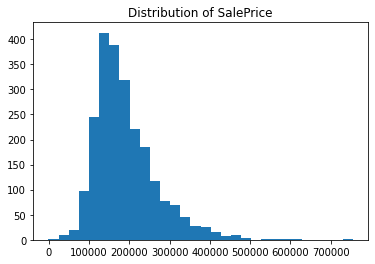

In [10]:
# Plot distribution of lenghts
plt.title('Distribution of SalePrice')
n, bins, patches = plt.hist(df['SalePrice'], bins=30)
plt.show()

## Tratamientos previos

In [12]:
# Fijándonos en las áreas, vemos que hay outliers, ya que hay inmuebles,
# por ejemplo lo vemos con GrLivArea, que tienen >4000 pies^2 de superficie,
# pero su precio es bajo. por tanto, los eliminamos porque podemos considerarlos outliers

print('Antes:', df.shape)
df = df[~((df['GrLivArea']>4000)&(df['SalePrice']<2e5))]
print('Después:', df.shape)

Antes: (2302, 81)
Después: (2299, 81)


In [13]:
df[target].min(), df[target].max()

(-965.1746805, 755000.0)

In [14]:
# df[target+'_log'] = np.log1p(df[target])
# Hay solo un registro cuyo precio es negativo y nos da problemas al aplicar logaritmo
# df[df[target+'_log'].isnull()]

# Para poder aplicarlo, lo eliminamos:
print('Antes:', df.shape)
df = df[df[target]>0]
print('Después:', df.shape)

Antes: (2299, 81)
Después: (2298, 81)


In [16]:
# Ahora sí, aplicamos transformación logarítmica (1+x)
df[target] = np.log1p(df[target])

In [18]:
len_traindf=df.shape[0]
print(df.shape, eval_df.shape)
houses= pd.concat([df, eval_df], sort=False)
print(houses.shape)

(2298, 81) (628, 80)
(2926, 81)


# Imputación de missings

In [19]:
missing=round((houses.isnull().sum()/houses.shape[0]),3)*100
missing.sort_values(ascending=False).head()

PoolQC         99.7
MiscFeature    96.4
Alley          93.2
Fence          80.5
FireplaceQu    48.7
dtype: float64

In [20]:
print('Antes: ',houses.shape)
cols_elim_miss = list(missing[missing>93].index)
print('Eliminadas: ',cols_elim_miss)
houses = houses.drop(cols_elim_miss, axis=1)
print('Después: ',houses.shape)

Antes:  (2926, 81)
Eliminadas:  ['Alley', 'PoolQC', 'MiscFeature']
Después:  (2926, 78)


In [21]:
cat_cols = list(houses.select_dtypes(include=['object']).columns)
num_cols = list(houses.select_dtypes(exclude=['object']).columns)
num_cols.remove(target)
len(cat_cols), len(num_cols)

(40, 37)

## Categóricos

In [22]:
# En la descripción de los datos especifica:
# Functional: Home functionality (Assume typical unless deductions are warranted)
houses['Functional'] = houses['Functional'].fillna('Typ')

In [23]:
pocos_missings_cat = ['Electrical','KitchenQual','Exterior1st','Exterior2nd','SaleType','MSZoning','Utilities','MasVnrType']
# MasVnrType: 24, MSZoning: 4, los demás: 1


# Así de primeras podría probar a imputar su clase más frecuente (moda)

for col in pocos_missings_cat:
    houses[col]=houses[col].fillna(houses[col].mode()[0])

In [24]:
# Resto de Categoricas
for col in cat_cols:
    houses[col]=houses[col].fillna('None')

## Numéricos

In [25]:
# from fancyimpute import IterativeImputer

In [26]:
# # Impute Continues missing values using Multiple Imputation by Chained Equations (MICE)
# MICE_imputer = IterativeImputer()
# #house_data_mice = MICE_imputer.fit_transform(df[num_cols])

# df_num_imp = pd.DataFrame(data=MICE_imputer.fit_transform(df[num_cols]), columns=df[num_cols].columns)
# eval_df_cat_imp = pd.DataFrame(data=MICE_imputer.fit_transform(eval_df[list(set(num_cols)-set(['SalePrice']))]), columns=eval_df[list(set(num_cols)-set(['SalePrice']))].columns)

In [27]:
# from sklearn.impute import KNNImputer
# PEORES RESULTADOS QUE Iterative

In [28]:
# # Impute Continues missing values using Multiple Imputation by Chained Equations (MICE)
# knn_imputer = KNNImputer(n_neighbors=2)
# #house_data_mice = MICE_imputer.fit_transform(df[num_cols])

# df_num_imp = pd.DataFrame(data=knn_imputer.fit_transform(df[num_cols]), columns=df[num_cols].columns)
# eval_df_cat_imp = pd.DataFrame(data=knn_imputer.fit_transform(eval_df[list(set(num_cols)-set(['SalePrice']))]), columns=eval_df[list(set(num_cols)-set(['SalePrice']))].columns)

In [29]:
# # Numerical
# for col in ('MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath',
#             'GarageYrBlt','GarageCars','GarageArea','LotFrontage'):
#     df[col]=df_num_imp[col]
#     eval_df[col]=eval_df_cat_imp[col]

In [30]:
# Para la longitud de la fachada, lo más preciso sería imputarle la mediana de su barrio
houses['LotFrontage'] = houses['LotFrontage'].fillna(houses.groupby('Neighborhood')['LotFrontage'].transform('median'))

In [31]:
# Numerical

for col in num_cols:
    houses[col]=houses[col].fillna(0)

# Feature Engineering

In [32]:
# CREACIÓN DE UN RANKING PARA EL BARRIO
neigh_ranking = houses.groupby(['Neighborhood'])[['SalePrice']].median().sort_values("SalePrice",ascending=False)\
.reset_index().reset_index().rename(columns={"index":"ranking"})

In [33]:
ranking_dict = dict(zip(neigh_ranking.Neighborhood, neigh_ranking.ranking))

In [34]:
# Ranking para el barrio
houses['Neighborhood_rank'] = houses['Neighborhood'].map(ranking_dict)

In [35]:
# Superficie total combinando sótano, 1ª planta y 2ª planta
houses['TotalSF'] = houses['TotalBsmtSF'] + houses['1stFlrSF'] + houses['2ndFlrSF']

In [36]:
# Superficie total combinando sótano, 1ª planta y 2ª planta Y GARAGE
houses['TotalSF_and_Garage'] = houses['TotalBsmtSF'] + houses['1stFlrSF'] + houses['2ndFlrSF'] + houses["GarageArea"]

In [37]:
# Superficie total, sumando todo lo posible
houses["TotalPlace"] = houses["TotalBsmtSF"] + houses["1stFlrSF"] + houses["2ndFlrSF"] + houses["GarageArea"] + houses["OpenPorchSF"]+houses["EnclosedPorch"]+houses["3SsnPorch"]+houses["ScreenPorch"]

In [38]:
# Habitaciones como tal
houses["Rooms"] = houses["FullBath"]+houses["TotRmsAbvGrd"]

In [39]:
# Superficie total sumando porches, cubiertas, etc.
houses['TotalPorchSF'] = (houses['WoodDeckSF'] +houses['OpenPorchSF'] + houses['3SsnPorch'] +
                              houses['EnclosedPorch'] + houses['ScreenPorch'])

In [40]:
# # Precio / pies^2 (no sotano)
# houses['SalePrice/GrLivArea_log'] = houses['SalePrice']/houses['GrLivArea']

In [41]:
# # Precio / pies^2 (totales)
# houses['SalePrice/TotalSF_log'] = houses['SalePrice']/houses['TotalSF']

In [42]:
# Años transcurridos desde remodelación
houses['YearsSinceRemod'] = houses['YrSold'] - houses['YearRemodAdd']

In [43]:
houses['CentralAir'] = houses['CentralAir'].apply(lambda x: 1 if x=='Y' else 0)

In [44]:
# Binaria tiene piscina
houses['IsNew'] = houses['SaleType'].apply(lambda x: 1 if x=='New' else 0)

In [45]:
# Binaria tiene piscina
houses['HasPool'] = houses['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

In [46]:
# Binaria tiene garage
houses['HasGarage'] = houses['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

In [47]:
# Binaria tiene garage
houses['HasPorch'] = houses['TotalPorchSF'].apply(lambda x: 1 if x > 0 else 0)

In [48]:
# Binaria tiene chimenea
houses['HasFireplace'] = houses['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [49]:
# Binaria tiene plantas 1 y 2 si son mayores que 0
houses['Has1stFlr'] = houses['1stFlrSF'].apply(lambda x: 1 if x > 0 else 0)
houses['Has2ndFlr'] = houses['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

In [50]:
# Binaria tiene sótano
houses['HasBsmt'] = houses['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

In [51]:
# Atendiendo a la descripción, esta es categórica, mejor cambiar su tipo
houses['MSSubClass'] = houses['MSSubClass'].apply(str)

In [52]:
# Baños totales contando medios baños
houses['TotalBathrooms'] = houses['FullBath'] + houses['BsmtFullBath'] + 0.5 * (houses['BsmtHalfBath']+houses['HalfBath'])

Para los materiales de algunas estructuras, se puede establecer un cierto orden de calidad que puede mejorar la performance del modelo:

In [53]:
# Cimentación
houses['Foundation_sc'] = houses['Foundation'].map({'Slab':1, 
                                       'BrkTil':2, 'CBlock':2, 'Stone':2,
                                       'Wood':3, 'PConc':4})

In [54]:
# Materiales de recubrimiento de la casa
for col in ["Exterior1st", "Exterior2nd"]:
    houses[col+'_sc'] = houses[col].map({'BrkComm':1, 'AsphShn':1, 'CBlock':1, 'AsbShng':1,
                                         'WdShing':2, 'Wd Sdng':2, 'MetalSd':2, 'Stucco':2, 'HdBoard':2,
                                         'BrkFace':3, 'Plywood':3,
                                         'VinylSd':4, 'CemntBd':4,
                                         'Stone':5, 'ImStucc':5})
    
houses['Exterior2nd_sc']=houses['Exterior2nd_sc'].fillna(houses['Exterior2nd_sc'].mode()[0])

In [55]:
# Asignar LabelEnc
for col in ['ExterQual','ExterCond','HeatingQC','KitchenQual']:
    houses[col]= houses[col].map({"Ex": 5, "Gd": 4 , "TA": 3, "Fa":2, "Po":1})

In [56]:
# Asignar LabelEnc
for col in ['BsmtQual', 'BsmtCond', 'FireplaceQu','GarageQual','GarageCond']:
    houses[col]= houses[col].map({"Ex": 5, "Gd": 4 , "TA": 3, "None": 2.5, "Fa":2, "Po":1})

In [57]:
# Asignar LabelEnc
for col in ['BsmtFinType1', 'BsmtFinType2']:
    houses[col]= houses[col].map({"GLQ": 7, "ALQ": 6 , "BLQ": 2, "Rec": 5, "LwQ":1, "Unf":4, "NA":0, "None":3})

In [58]:
# Más de lo mismo para el tipo de garaje
houses['GarageType_sc'] = houses['GarageType'].map({'CarPort':1, 'None':0, 'Detchd':2,
                                               '2Types':3, 'Basment':3, 'Attchd':4,
                                               'BuiltIn':5})

In [59]:
# Lo mismo en cuanto a si el garaje está terminado
houses['GarageFinish_sc'] = houses['GarageFinish'].map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})

In [60]:
year_features = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
for col in year_features:
    houses[col] = LabelEncoder().fit_transform(houses[col])

## Skewed features: log transformation

In [61]:
from scipy.stats import skew

In [62]:
#log transform skewed numeric features:
numeric_feats = houses.dtypes[houses.dtypes != "object"].index
print(list(numeric_feats))

['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'Neighborhood_rank', 'TotalSF', 'TotalSF_and_Garage', 'TotalPlace', 'Rooms', 'TotalPorchSF', 'YearsSinceRemod', 'IsNew', 'HasPool', 'HasGarage', 'HasPorch', 'HasFireplace', 'Has1stFlr', 'Has2ndFlr', 'HasBsmt', 'TotalBathrooms', 'Foundation_sc', 'Exterior1st_sc', 'Exterior2nd_sc', 'GarageType_sc', 'GarageFinish_sc']


In [63]:
skewed_feats = houses[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
print(skewed_feats.sort_values(ascending=False).head())
skewed_feats = skewed_feats[skewed_feats > 0.75].index.tolist()
len(skewed_feats)

MiscVal         20.698249
PoolArea        17.716191
HasPool         15.518938
LotArea         13.145162
LowQualFinSF    12.103527
dtype: float64


24

In [64]:
houses[skewed_feats] = np.log1p(houses[skewed_feats])

Las 2 de a continuación son serias candidatas a desaparecer:

In [65]:
houses['Utilities'].value_counts(dropna=False)

AllPub    2924
NoSeWa       2
Name: Utilities, dtype: int64

In [66]:
houses['Street'].value_counts(dropna=False)

Pave    2913
Grvl      13
Name: Street, dtype: int64

In [67]:
houses = houses.drop(['Utilities'], axis=1)

## Crear todo tipo de features:
Si terminamos haciendo PCA, no importa colinealidad

In [68]:
houses["TotalHouse_OverallQual"] = houses["TotalSF"] * houses["OverallQual"]
houses["TotalSF_and_Garage_OverallQual"] = houses["TotalSF_and_Garage"] * houses["OverallQual"]
houses["GrLivArea_OverallQual"] =houses["GrLivArea"] * houses["OverallQual"]

In [69]:
num_cols_ = list(houses.select_dtypes(exclude=['object']).columns)
this_num_cols = [elem for elem in num_cols_ if elem not in ['SalePrice','Id']]

# Feature selection

Guardamos correlation matrix para poder ampliarla y verla mejor:

In [70]:
def plot_corr_matrix(df, method_='pearson'):
    # Generate correlation matrix in Pandas
    corr = df.select_dtypes(include=np.number).corr(method=method_)
    corr = np.round(corr,2)

    # Mask to show only one triangle and improve the presentation
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Plotea correlation matrix
    f, ax = plt.subplots(figsize=(30, 25))
    fig = sns.heatmap(corr, mask=mask, cmap='RdBu_r', center=0)#, annot=True, annot_kws={"fontsize":8})
    plt.savefig('final_correlations.png')
    plt.show()

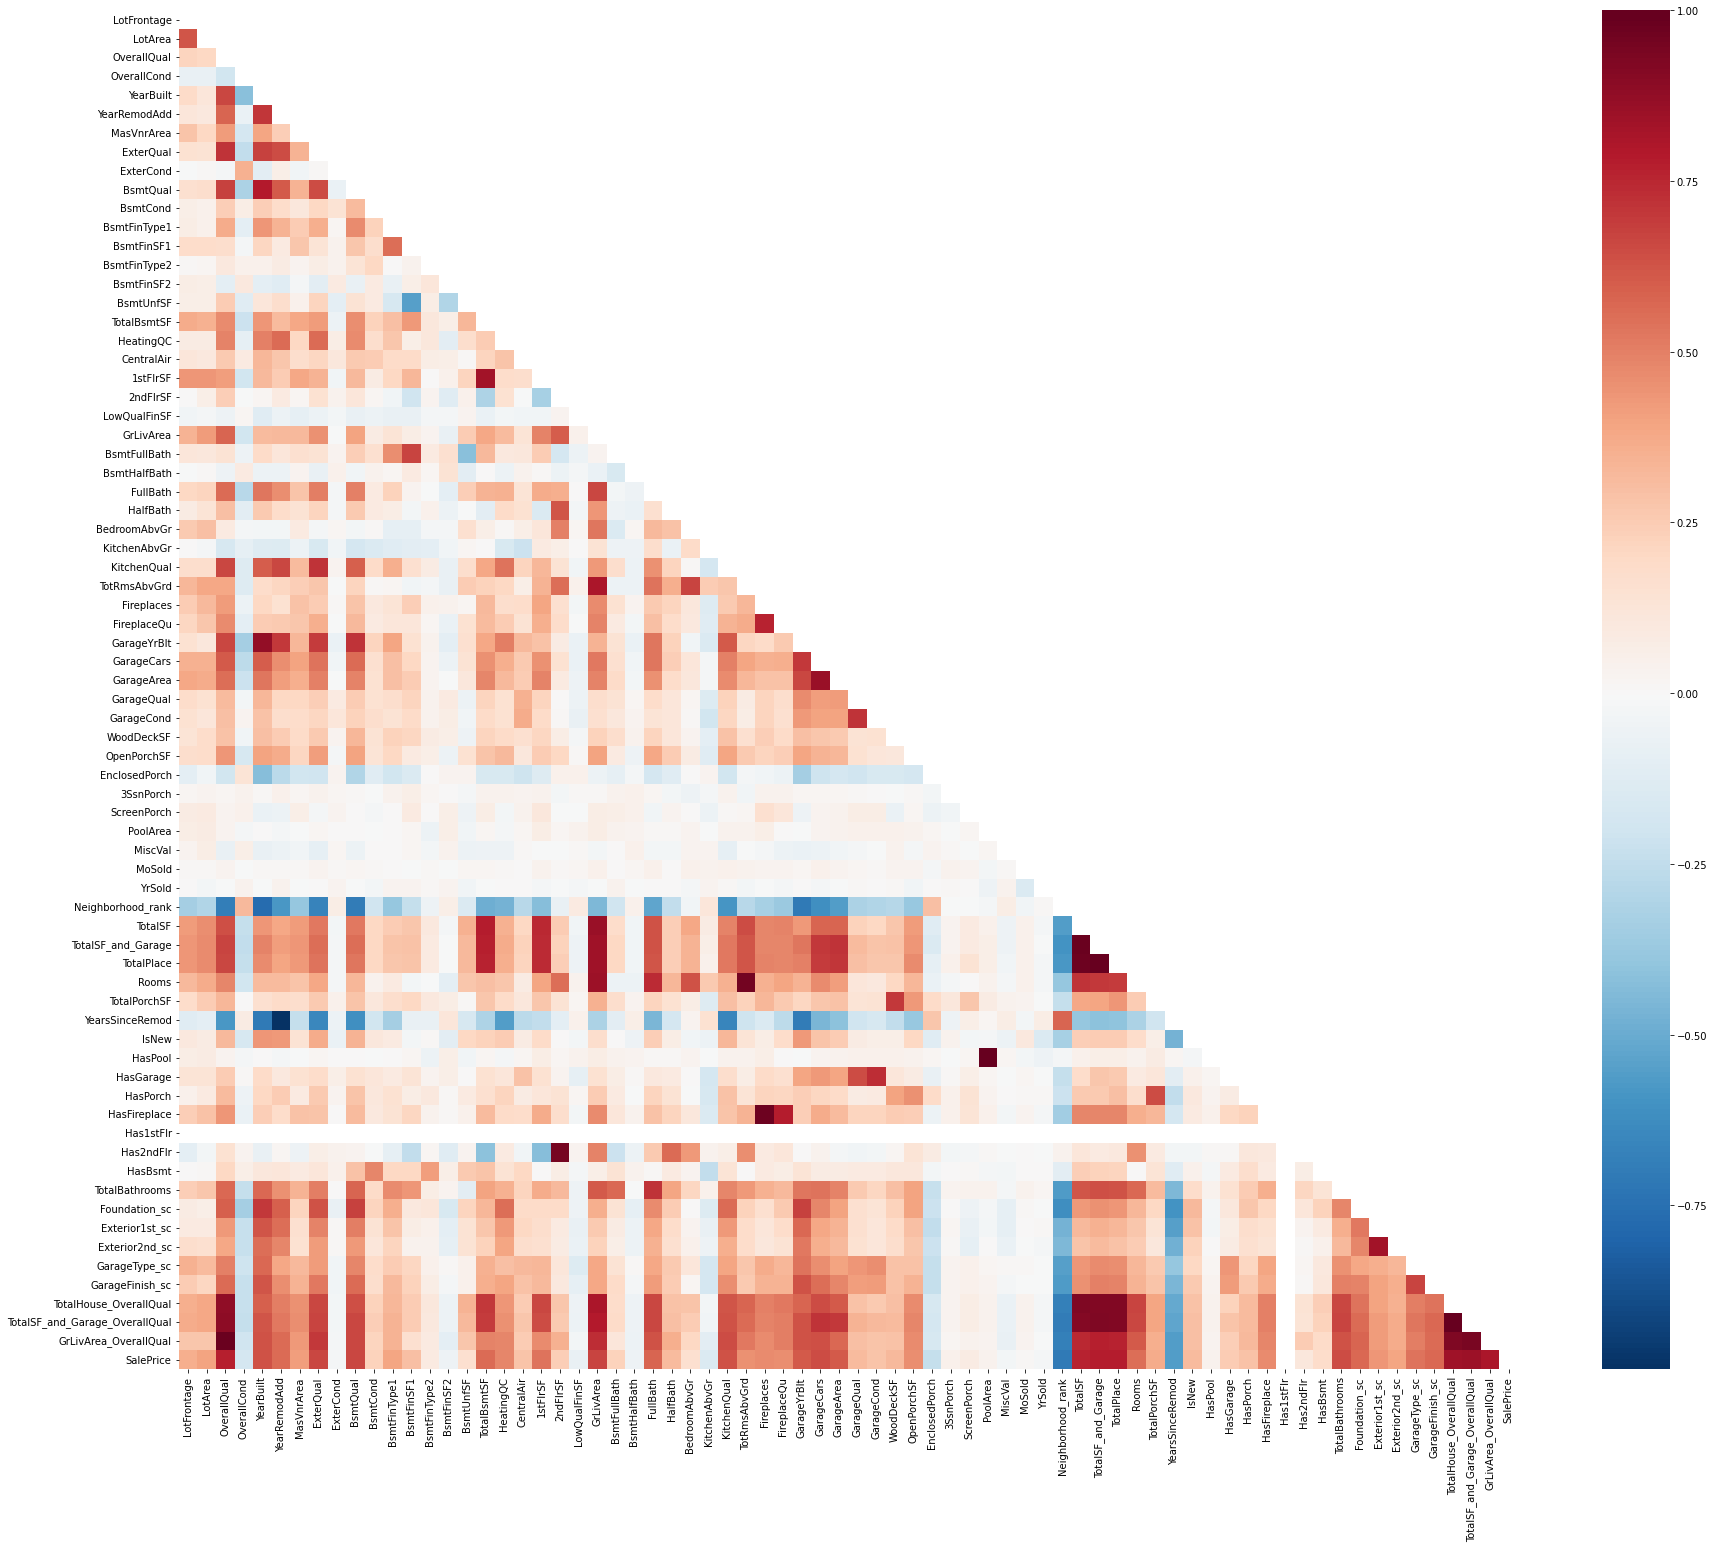

In [71]:
plot_corr_matrix(houses[this_num_cols+['SalePrice']],'spearman')  # Plot spearman's correlation matrix

## Transformación de categóricas

**Dummies**

In [72]:
# print(houses.shape)
# houses = to_dummies(houses)
# print(houses.shape)

**Target encoding** (proven to achieve lower RMSE than dummies)

In [73]:
import category_encoders as ce

In [74]:
encoder = ce.SummaryEncoder(quantiles=(0.15, 0.5, 0.85), return_df=True)

# Train/Test split

In [75]:
# X = houses.drop(target,axis=1)
# Y = houses[target]
# print(X.shape, Y.shape)

In [76]:
houses_ = houses[:len_traindf]
houses_Y = houses[:len_traindf][target]
X_eval = houses[len_traindf:]#.drop(target,axis=1)

houses_.shape, houses_Y.shape, X_eval.shape

((2298, 101), (2298,), (628, 101))

In [77]:
houses__te = encoder.fit_transform(houses_,houses_Y)
X_eval = encoder.transform(X_eval).drop(target,axis=1)

In [78]:
# '.sample(frac=1)': Prior to modeling, it is a good practice to
#                    randomly order the rows of the dataset.
houses__te = houses__te.sample(frac=1, random_state=42)

In [79]:
train_test_ratio = 0.90  # 80% train / 20% test
train_test_index = int(train_test_ratio*len(houses_))

In [80]:
X_train = houses__te[:train_test_index].drop(target,axis=1)
Y_train = houses__te[:train_test_index][target]

X_test = houses__te[train_test_index:].drop(target,axis=1)
Y_test = houses__te[train_test_index:][target]

print('X_train: ', X_train.shape, 'X_test:', X_test.shape)
print('Y_train: ', Y_train.shape, 'Y_test:', Y_test.shape)
print('X_eval:', X_eval.shape)

X_train:  (2068, 156) X_test: (230, 156)
Y_train:  (2068,) Y_test: (230,)
X_eval: (628, 156)


# Lasso Feature selection

## First, scale

In [81]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [82]:
scaler = RobustScaler()
X_train_scaled = scaler.fit(houses__te.drop(target,axis=1)).transform(houses__te.drop(target,axis=1))

## Then, Lasso

In [83]:
from sklearn.linear_model import Lasso, Ridge

In [84]:
lasso=Lasso(alpha=0.001)
lasso.fit(X_train_scaled,houses__te[target])

Lasso(alpha=0.001)

In [85]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=X_train.columns).sort_values("Feature Importance",ascending=False)

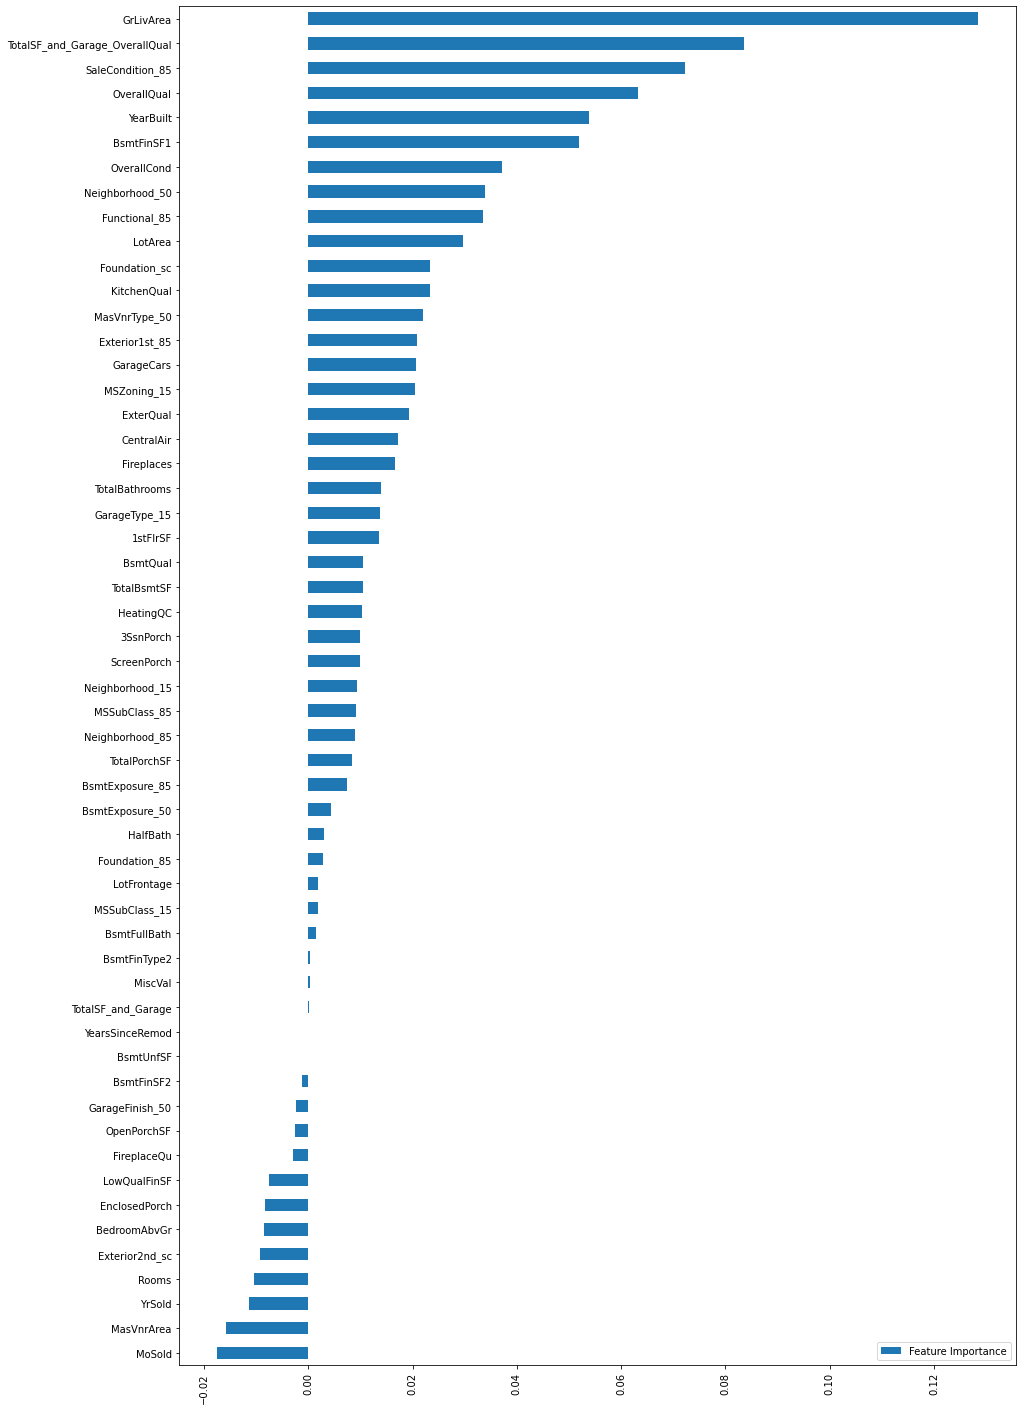

In [86]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

# MODEL

In [87]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [88]:
param_grid1 = {"max_depth":[2, 4, 6], # maximum depth of each tree - try 2 to 10
               "learning_rate":[0.01, 0.05], # effect of each tree - try 0.0001 to 0.1
               "n_estimators":[150, 250, 500], # number of trees (that is, boosting rounds) - try 1000 to 8000
               "min_child_weight":[1, 2, 3], # minimum number of houses in a leaf - try 1 to 10
               "colsample_bytree":[0.4, 0.6, 0.8], # fraction of features (columns) per tree - try 0.2 to 1.0
               "subsample":[0.4, 0.6, 0.8], # fraction of instances (rows) per tree - try 0.2 to 1.0
               "reg_alpha":[1, 3], # L1 regularization (like LASSO) - try 0.0 to 10.0
               "reg_lambda":[0, 1]} # L2 regularization (like Ridge) - try 0.0 to 10.0

keys = param_grid1.keys()
values = (param_grid1[key] for key in keys)
# make a list of dictionaries containing every possible combination in the grid as a dict
param_grid1_f = [dict(zip(keys, param_grid1)) for param_grid1 in itertools.product(*values)]

print(str(len(param_grid1_f)) + ' combinaciones')

1944 combinaciones


In [90]:
model = xgb.XGBRegressor(n_jobs=-1)

model_gs = GridSearchCV(model,
                        param_grid=param_grid1,
                        scoring='neg_mean_squared_error',
                        cv=2)

In [91]:
%%time
model_gs.fit(X_train,
             Y_train)#,
             # verbose=1)

print(model_gs.best_score_)
print(model_gs.best_params_)
best_model = model_gs.best_estimator_
best_model

-0.033469117479540546
{'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 250, 'reg_alpha': 1, 'reg_lambda': 0, 'subsample': 0.8}
Wall time: 58min 42s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=2,
             missing=nan, monotone_constraints='()', n_estimators=250,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=1, reg_lambda=0, ...)

In [104]:
mse = mean_squared_error(np.expm1(Y_test), np.expm1(best_model.predict(X_test)))
rmse = np.sqrt(mse)
print(rmse)

29769.429671156027


## Re-train with complete data

In [105]:
# Concatenate vertically X_train and X_test and re-train

X_complete = pd.concat([X_train, X_test], sort=False)
Y_complete = pd.concat([Y_train, Y_test], sort=False)
print(X_complete.shape, Y_complete.shape)

(2298, 156) (2298,)


In [106]:
model_complete = xgb.XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=2,
             missing=np.nan, monotone_constraints='()', n_estimators=250,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=1, reg_lambda=0).fit(X_complete,Y_complete)

In [107]:
mse = mean_squared_error(np.expm1(Y_test), np.expm1(model_complete.predict(X_test)))
rmse = np.sqrt(mse)
print(rmse)

21101.602963693364


In [108]:
mse = mean_squared_error(np.expm1(Y_complete), np.expm1(model_complete.predict(X_complete)))
rmse = np.sqrt(mse)
print(rmse)

24650.89311896193


## Generate the submission

In [109]:
preds_enriq_log = model_complete.predict(X_eval)
preds_enriq = np.expm1(preds_enriq_log)
pd.DataFrame(preds_enriq).describe()

,0
count,628.000000
mean,189905.656250
std,75227.562500
min,47665.636719
25%,137717.289062
50%,171718.984375
75%,229500.843750
max,510522.687500


In [110]:
cols_submission = ['Id',target]

sumbission_path = './submissions/2022-06-19/2022-06-19_final.csv'

eval_df[target]=preds_enriq
prediction=eval_df[cols_submission]
print(prediction.shape)
sumbission_path

(628, 2)


'./submissions/2022-06-19/2022-06-19_final.csv'

In [111]:
prediction.to_csv(sumbission_path, index=False)

In [112]:
# Save model
pickle.dump(model_complete, open("xgb_regression.pickle", "wb"))

In [114]:
# Load model
pickled_model = pickle.load(open('xgb_regression.pickle', 'rb'))